# 상권변화지표 EDA

- 젠트리피케이션 상권 지역은 폐업 영업 평균 개월 수가 짧아질 것이다.


## 라이브러리 임포트


In [61]:
import os
import psycopg2
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from dotenv import load_dotenv

In [62]:
# Warning 무시
warnings.filterwarnings('ignore', category=UserWarning)

# Seaborn 테마 설정
sns.set_theme(style='whitegrid')

# matplotlib 한글 폰트 설정
os.system('rm -rf ~/.cache/matplotlib')
os.system('fc-cache -fv')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

/usr/share/fonts: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cMap: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap: caching, new cache contents: 0 fonts, 5 dirs
/usr/share/fonts/cmap/adobe-cns1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-gb1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-japan2: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/cmap/adobe-korea1: caching, new cache contents: 0 fonts, 0 dirs
/usr/share/fonts/opentype: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/opentype/urw-base35: caching, new cache contents: 35 fonts, 0 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 6 fonts, 0 dirs
/usr/share/fonts/truetype/droid: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts

## 데이터 불러오기


In [ ]:
# 환경 변수 로드
load_dotenv()

# DB 구성 객체
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', 5432),
    'database': os.getenv('DB_NAME', 'postgres'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'postgres')
}

In [ ]:
conn = psycopg2.connect(
    host=DB_CONFIG['host'],
    port=DB_CONFIG['port'],
    database=DB_CONFIG['database'],
    user=DB_CONFIG['user'],
    password=DB_CONFIG['password'],
    client_encoding='UTF8'
)

if conn is None:
  print("Connection failed")

### 상권 상권변화지표 데이터 로드


In [65]:
df_origin_dong = pd.read_sql_query('SELECT * FROM position.seoul_biz_dist_dong_radius_500m', conn)
df_origin_indicators = pd.read_sql_query('SELECT * FROM more.seoul_biz_dist_indicators_of_commercial_change', conn)

In [66]:
df_dong = pd.json_normalize(df_origin_dong['data'].tolist())
df_indicators = pd.json_normalize(df_origin_indicators['data'].tolist())

## 데이터 전처리


### 상권, 상권그룹, 구분 및 상권변화지표 병합


In [67]:
# 필요한 컬럼만 선택
df_dong = df_dong[['상권', '상권그룹', '구분']]

# 상권그룹과 구분를 상권에 따라 매칭
df_dong_indicators = df_indicators.merge(df_dong, how='left', left_on='상권', right_on='상권')

# 상권그룹과 구분 기본값 설정
df_dong_indicators['상권그룹'] = df_dong_indicators['상권그룹'].fillna('기본')
df_dong_indicators['구분'] = df_dong_indicators['구분'].fillna('기본')

# 상권코드명 기준으로 중복 제거
df_dong_indicators = df_dong_indicators.drop_duplicates(subset=['상권코드'])

# 연도분기 기준으로 오름차순 정렬
df_dong_indicators = df_dong_indicators.sort_values(by='연도분기', ascending=True).reset_index(drop=True)

# 데이터 확인
df_dong_indicators.head()

,연도분기,상권구분코드,상권구분,상권코드,상권,상권변화지표코드,상권변화지표,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균,상권그룹,구분
0,20191,A,골목상권,3110697,개봉3동주민센터,LL,다이나믹,93,36,93,48,기본,기본
1,20191,A,골목상권,3111041,거여역 8번,LH,상권확장,79,61,93,48,기본,기본
2,20191,R,전통시장,3130325,명일전통시장,HL,상권축소,100,47,93,48,기본,기본
3,20191,R,전통시장,3130327,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",LH,상권확장,87,62,93,48,동대문(DDP),비젠트리피케이션
4,20191,A,골목상권,3111037,Sh수협은행 오금동금융센터(아랫말어린이공원),LH,상권확장,89,55,93,48,기본,기본


In [68]:
df_dong_indicators.tail()

,연도분기,상권구분코드,상권구분,상권코드,상권,상권변화지표코드,상권변화지표,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균,상권그룹,구분
1645,20244,R,전통시장,3130019,동대문상가D동,LH,상권확장,103,68,109,52,동대문(DDP),비젠트리피케이션
1646,20244,R,전통시장,3130018,동대문문구완구거리(동대문문구완구시장),HH,정체,149,67,109,52,동대문(DDP),비젠트리피케이션
1647,20244,U,관광특구,3001495,잠실 관광특구,LL,다이나믹,94,51,109,52,잠실역,비젠트리피케이션
1648,20244,R,전통시장,3130264,상도약수골목형상점가,LL,다이나믹,108,50,109,52,기본,기본
1649,20244,U,관광특구,3001496,강남 마이스 관광특구,HH,정체,116,66,109,52,기본,기본


In [69]:
df_dong_indicators.isna().sum()

연도분기          0
상권구분코드        0
상권구분          0
상권코드          0
상권            0
상권변화지표코드      0
상권변화지표        0
운영영업개월평균      0
폐업영업개월평균      0
서울운영영업개월평균    0
서울폐업영업개월평균    0
상권그룹          0
구분            0
dtype: int64

### 구분 및 상권그룹 데이터프레임 생성


In [70]:
# 구분별로 개별 데이터프레임 생성
for cat in df_dong_indicators['구분'].unique():
  df_name = f"df_category_{cat.replace(' ', '_')}"
  globals()[df_name] = df_dong_indicators[df_dong_indicators['구분'] == cat].reset_index(drop=True)
  print(f"생성된 데이터프레임: {df_name}")

# 상권그룹별로 개별 데이터프레임 생성
for addr in df_dong_indicators['상권그룹'].unique():
  df_name = f"df_bd_group_{addr.replace(' ', '_')}"
  globals()[df_name] = df_dong_indicators[df_dong_indicators['상권그룹'] == addr].reset_index(drop=True)
  print(f"생성된 데이터프레임: {df_name}")

생성된 데이터프레임: df_category_기본
생성된 데이터프레임: df_category_비젠트리피케이션
생성된 데이터프레임: df_category_젠트리피케이션
생성된 데이터프레임: df_bd_group_기본
생성된 데이터프레임: df_bd_group_동대문(DDP)
생성된 데이터프레임: df_bd_group_신림
생성된 데이터프레임: df_bd_group_영등포
생성된 데이터프레임: df_bd_group_사당
생성된 데이터프레임: df_bd_group_이수역
생성된 데이터프레임: df_bd_group_청담
생성된 데이터프레임: df_bd_group_문래
생성된 데이터프레임: df_bd_group_해방촌(이태원_근처)
생성된 데이터프레임: df_bd_group_종로3가
생성된 데이터프레임: df_bd_group_송리단길
생성된 데이터프레임: df_bd_group_대학로(혜화역)
생성된 데이터프레임: df_bd_group_북촌
생성된 데이터프레임: df_bd_group_서촌
생성된 데이터프레임: df_bd_group_강남역
생성된 데이터프레임: df_bd_group_압구정로데오
생성된 데이터프레임: df_bd_group_회기역
생성된 데이터프레임: df_bd_group_명동
생성된 데이터프레임: df_bd_group_여의도역
생성된 데이터프레임: df_bd_group_용리단길
생성된 데이터프레임: df_bd_group_신사동_가로수길
생성된 데이터프레임: df_bd_group_성수동
생성된 데이터프레임: df_bd_group_건대입구역
생성된 데이터프레임: df_bd_group_경리단길
생성된 데이터프레임: df_bd_group_합정
생성된 데이터프레임: df_bd_group_홍대입구역
생성된 데이터프레임: df_bd_group_연남
생성된 데이터프레임: df_bd_group_잠실역


## 구분 데이터 분석


### 데이터 확인


In [71]:
df_category_젠트리피케이션.head()

,연도분기,상권구분코드,상권구분,상권코드,상권,상권변화지표코드,상권변화지표,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균,상권그룹,구분
0,20191,A,골목상권,3110871,신원동주민센터,LL,다이나믹,81,44,93,48,신림,젠트리피케이션
1,20191,A,골목상권,3110851,경문고등학교(동작동성당),LL,다이나믹,77,48,93,48,이수역,젠트리피케이션
2,20191,A,골목상권,3110877,신림역 8번,LL,다이나믹,85,48,93,48,신림,젠트리피케이션
3,20191,A,골목상권,3110883,은천초등학교(은천교앞),LL,다이나믹,88,43,93,48,신림,젠트리피케이션
4,20191,A,골목상권,3110759,문래예술촌(문래창작촌),LH,상권확장,90,51,93,48,문래,젠트리피케이션


In [72]:
df_category_비젠트리피케이션.head()

,연도분기,상권구분코드,상권구분,상권코드,상권,상권변화지표코드,상권변화지표,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균,상권그룹,구분
0,20191,R,전통시장,3130327,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",LH,상권확장,87,62,93,48,동대문(DDP),비젠트리피케이션
1,20191,A,골목상권,3110788,영등포시장역 3번,LH,상권확장,83,65,93,48,영등포,비젠트리피케이션
2,20191,A,골목상권,3110913,방현초등학교(방배119안전센터),HL,상권축소,99,48,93,48,사당,비젠트리피케이션
3,20191,A,골목상권,3110911,방배배수지체육공원,HL,상권축소,112,39,93,48,사당,비젠트리피케이션
4,20191,A,골목상권,3110987,영동대교남단,LL,다이나믹,68,44,93,48,청담,비젠트리피케이션


In [73]:
df_category_기본.head()

,연도분기,상권구분코드,상권구분,상권코드,상권,상권변화지표코드,상권변화지표,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균,상권그룹,구분
0,20191,A,골목상권,3110697,개봉3동주민센터,LL,다이나믹,93,36,93,48,기본,기본
1,20191,A,골목상권,3111041,거여역 8번,LH,상권확장,79,61,93,48,기본,기본
2,20191,R,전통시장,3130325,명일전통시장,HL,상권축소,100,47,93,48,기본,기본
3,20191,A,골목상권,3111037,Sh수협은행 오금동금융센터(아랫말어린이공원),LH,상권확장,89,55,93,48,기본,기본
4,20191,R,전통시장,3130289,봉일시장,HH,정체,107,54,93,48,기본,기본


### 기본통계분석


| 지표                 | 젠트리피케이션 | 비젠트리피케이션 | 기본상권지 |
| -------------------- | -------------- | ---------------- | ---------- |
| 운영영업개월평균     | 99.76개월      | 104.99개월       | 103.97개월 |
| 폐업영업개월평균     | 52.38개월      | 54.60개월        | 50.96개월  |
| 서울운영영업개월평균 | 97.60개월      | 97.12개월        | 99.62개월  |
| 서울폐업영업개월평균 | 49.87개월      | 49.67개월        | 50.67개월  |

---

운영영업개월 평균

- 젠트리피케이션 (99.76개월) < 기본상권지 (103.97개월) < 비젠트리피케이션 (104.99개월)
- 젠트리피케이션 지역에서 평균적으로 가게 운영 기간이 가장 짧다 → 상권이 불안정할 가능성이 있음.
- 반면, 비젠트리피케이션 지역에서는 가게가 오래 유지되는 경향을 보임.

폐업영업개월 평균

- 기본상권지 (50.96개월) < 젠트리피케이션 (52.38개월) < 비젠트리피케이션 (54.60개월)
- 비젠트리피케이션 지역에서 폐업하는 가게들이 가장 오래 운영된 후 문을 닫음.
- 젠트리피케이션 지역은 폐업 시점이 상대적으로 빠름.

서울 전체 평균과 비교

- 서울 전체 운영영업개월평균은 약 99.33개월이므로, 젠트리피케이션 지역(97.60개월)은 평균보다 낮음. 비젠트리피케이션 지역(104.99개월)은 평균보다 높음.
- 서울 전체 폐업영업개월평균은 50.55개월이므로, 젠트리피케이션(49.87개월)은 평균보다 조금 낮음. 비젠트리피케이션 지역(54.60개월)은 평균보다 높음.


In [74]:
# 데이터 타입 변환
df_dong_indicators['운영영업개월평균'] = pd.to_numeric(df_dong_indicators['운영영업개월평균'], errors='coerce')
df_dong_indicators['폐업영업개월평균'] = pd.to_numeric(df_dong_indicators['폐업영업개월평균'], errors='coerce')
df_dong_indicators['서울운영영업개월평균'] = pd.to_numeric(df_dong_indicators['서울운영영업개월평균'], errors='coerce')
df_dong_indicators['서울폐업영업개월평균'] = pd.to_numeric(df_dong_indicators['서울폐업영업개월평균'], errors='coerce')
df_category_젠트리피케이션['운영영업개월평균'] = pd.to_numeric(df_category_젠트리피케이션['운영영업개월평균'], errors='coerce')
df_category_젠트리피케이션['폐업영업개월평균'] = pd.to_numeric(df_category_젠트리피케이션['폐업영업개월평균'], errors='coerce')
df_category_젠트리피케이션['서울운영영업개월평균'] = pd.to_numeric(df_category_젠트리피케이션['서울운영영업개월평균'], errors='coerce')
df_category_젠트리피케이션['서울폐업영업개월평균'] = pd.to_numeric(df_category_젠트리피케이션['서울폐업영업개월평균'], errors='coerce')
df_category_비젠트리피케이션['운영영업개월평균'] = pd.to_numeric(df_category_비젠트리피케이션['운영영업개월평균'], errors='coerce')
df_category_비젠트리피케이션['폐업영업개월평균'] = pd.to_numeric(df_category_비젠트리피케이션['폐업영업개월평균'], errors='coerce')
df_category_비젠트리피케이션['서울운영영업개월평균'] = pd.to_numeric(df_category_비젠트리피케이션['서울운영영업개월평균'], errors='coerce')
df_category_비젠트리피케이션['서울폐업영업개월평균'] = pd.to_numeric(df_category_비젠트리피케이션['서울폐업영업개월평균'], errors='coerce')
df_category_기본['운영영업개월평균'] = pd.to_numeric(df_category_기본['운영영업개월평균'], errors='coerce')
df_category_기본['폐업영업개월평균'] = pd.to_numeric(df_category_기본['폐업영업개월평균'], errors='coerce')
df_category_기본['서울운영영업개월평균'] = pd.to_numeric(df_category_기본['서울운영영업개월평균'], errors='coerce')
df_category_기본['서울폐업영업개월평균'] = pd.to_numeric(df_category_기본['서울폐업영업개월평균'], errors='coerce')

In [75]:
df_dong_indicators.describe()

,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,1650.000000,1650.000000,1650.00000,1650.000000
mean,96.939394,49.252727,94.18303,48.430909
std,23.007710,8.202398,4.04573,1.060517
min,0.000000,21.000000,92.00000,48.000000
25%,84.000000,44.000000,93.00000,48.000000
50%,93.000000,48.000000,93.00000,48.000000
75%,107.000000,53.000000,93.00000,48.000000
max,262.000000,110.000000,109.00000,52.000000


In [76]:
df_category_젠트리피케이션.describe()

,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,127.000000,127.000000,127.000000,127.000000
mean,96.818898,51.440945,94.496063,48.535433
std,28.553602,9.719603,4.620304,1.193868
min,51.000000,32.000000,92.000000,48.000000
25%,77.000000,45.000000,93.000000,48.000000
50%,90.000000,49.000000,93.000000,48.000000
75%,108.000000,55.000000,93.000000,48.000000
max,194.000000,89.000000,109.000000,52.000000


In [77]:

df_category_비젠트리피케이션.describe()

,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,87.000000,87.000000,87.000000,87.000000
mean,100.816092,52.850575,95.206897,48.632184
std,31.983836,11.548209,5.346457,1.356423
min,0.000000,34.000000,92.000000,48.000000
25%,84.000000,44.000000,93.000000,48.000000
50%,96.000000,49.000000,93.000000,48.000000
75%,113.500000,57.000000,93.000000,48.000000
max,262.000000,97.000000,109.000000,52.000000


In [78]:
df_category_기본.describe()

,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,1436.000000,1436.000000,1436.000000,1436.000000
mean,96.715181,48.841226,94.093315,48.409471
std,21.781629,7.723163,3.891158,1.026218
min,27.000000,21.000000,92.000000,48.000000
25%,84.000000,44.000000,93.000000,48.000000
50%,93.000000,48.000000,93.000000,48.000000
75%,106.000000,52.000000,93.000000,48.000000
max,243.000000,110.000000,109.000000,52.000000


### 운영, 폐업 평균 분석


운영영업개월평균이 비젠트리피케이션 지역에서 가장 높고, 젠트리피케이션 지역에서 가장 낮음 -> 즉, 젠트리피케이션 지역에서는 상권 변동성이 크고, 가게가 오래 지속되지 않음.

폐업영업개월평균도 비슷한 경향을 보임 -> 비젠트리피케이션 지역은 가게가 오래 지속되다가 폐업하는 경우가 많음.


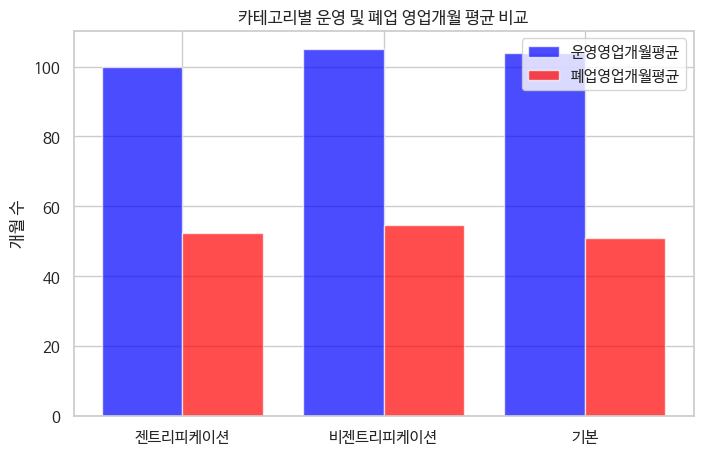

In [ ]:
categories = ['젠트리피케이션', '비젠트리피케이션', '기본']
op_mean = [99.76, 104.99, 103.97]  # 운영평균
cl_mean = [52.38, 54.60, 50.96]  # 폐업평균

fig, ax = plt.subplots(figsize=(8, 5))
x = range(len(categories))

ax.bar(x, op_mean, width=0.4, label='운영영업개월평균', color='blue', alpha=0.7)
ax.bar([i + 0.4 for i in x], cl_mean, width=0.4, label='폐업영업개월평균', color='red', alpha=0.7)

ax.set_xticks([i + 0.2 for i in x])
ax.set_xticklabels(categories)
ax.set_ylabel("개월 수")
ax.set_title("카테고리별 운영 및 폐업 영업개월 평균 비교")
ax.legend()

plt.show()

### 구분별 운영영업개월수 분포 분석


- 젠트리피케이션 지역의 운영영업개월수 분포가 다른 지역보다 낮은 범위에 있음.
- 비젠트리피케이션 지역은 전체적으로 높은 운영영업개월수를 보임.

즉, 젠트리피케이션 지역은 업장이 짧은 주기로 바뀌고, 비젠트리피케이션 지역은 안정적인 업장이 많음.


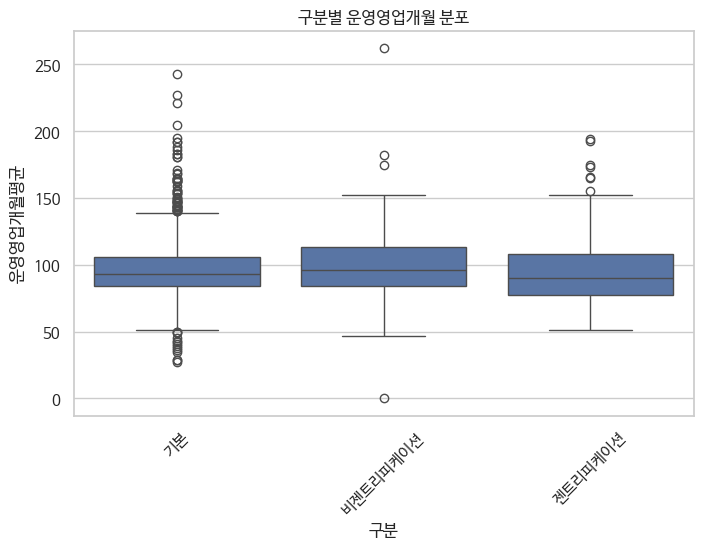

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_dong_indicators['구분'], y=df_dong_indicators['운영영업개월평균'])
plt.title("구분별 운영영업개월 분포")
plt.ylabel("운영영업개월평균")
plt.xlabel("구분")
plt.xticks(rotation=45)
plt.show()

### 폐업영업개월수, 운영영업개월수 분포 분석 (젠/비젠 데이터프레임 사용)


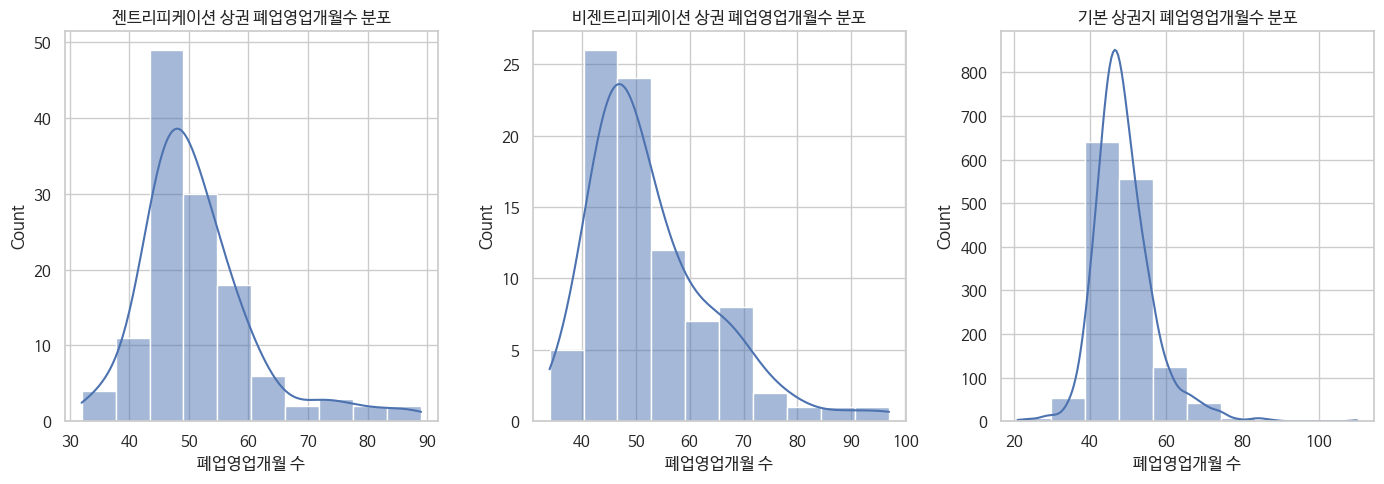

In [ ]:
dataframes = [df_category_젠트리피케이션, df_category_비젠트리피케이션, df_category_기본]
titles = ["젠트리피케이션 상권", "비젠트리피케이션 상권", "기본 상권지"]

plt.figure(figsize=(14, 5))

for i, (df, title) in enumerate(zip(dataframes, titles)):
  plt.subplot(1, 3, i + 1)
  sns.histplot(df["폐업영업개월평균"], kde=True, bins=10)
  plt.title(f"{title} 폐업영업개월수 분포")
  plt.xlabel("폐업영업개월 수")
  plt.ylabel("Count")

plt.tight_layout()
plt.show()

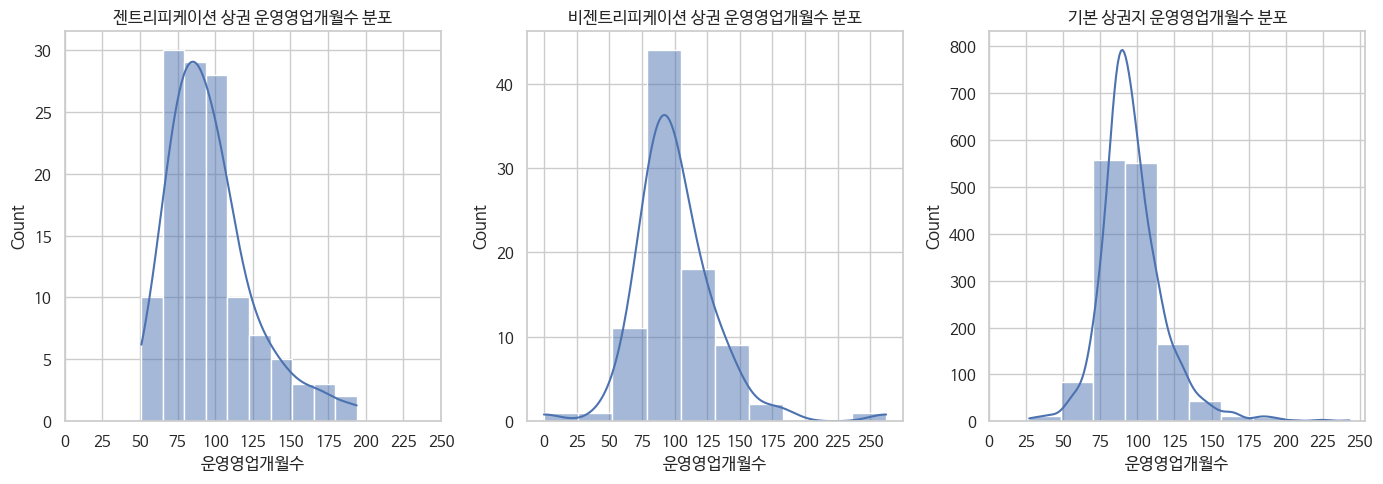

In [ ]:
plt.figure(figsize=(14, 5))

for i, (df, title) in enumerate(zip(dataframes, titles)):
  plt.subplot(1, 3, i + 1)
  sns.histplot(df["운영영업개월평균"], kde=True, bins=10)
  plt.title(f"{title} 운영영업개월수 분포")
  plt.xticks(range(0, 251, 25))
  plt.xlabel("운영영업개월수")
  plt.ylabel("Count")

plt.tight_layout()
plt.show()

**결론**

젠트리피케이션 지역은 상권 변동성이 크다.

- 운영 개월 수가 낮고, 폐업 개월 수도 낮아 짧은 기간 운영 후 폐업하는 경우가 많음.
- 이는 임대료 상승, 소비 패턴 변화 등의 영향을 받을 가능성이 큼.

비젠트리피케이션 지역은 상대적으로 안정적이다.

- 운영 개월 수도 길고, 폐업 개월 수도 길어 오래 유지되다가 문을 닫는 경향.
- 즉, 자연스러운 비즈니스 사이클에 의해 폐업하는 경우가 많음.

기본상권지는 중간 성향을 보인다.

- 운영/폐업 개월 수가 서울 평균과 비슷하며, 큰 변동성이 없는 일반적인 상권으로 볼 수 있음.


### 상권변화지표 분포 분석


**상권변화지표 의미**

- 다이나믹: 점포의 유입과 유출이 빈번하게 발생하는 상권 (변동성 높음)
- 상권확장: 상권의 규모가 커지고, 새로운 점포들이 지속적으로 유입되는 상태
- 상권축소: 기존 점포들이 사라지고, 새로운 점포가 적게 들어오면서 상권이 축소되는 상태
- 정체: 큰 변화 없이 기존 상권이 유지되는 상태

---

1. 기본상권지는 전반적으로 상권이 크고 안정적.

- 기본상권지에서는 정체(434개)와 다이나믹(457개)이 매우 많음.
  - 즉, 기본상권지는 변화가 적거나, 변화하더라도 활발한 순환이 이루어지는 편.
- 상권확장(210개)과 상권축소(335개)도 많음.
  - 즉, 기본상권지에서는 확장과 축소가 공존하지만, 비교적 지속성이 있음.

2. 젠트리피케이션 지역은 변화가 심하고 불안정

- 다이나믹 비율이 비젠트리피케이션보다 2배 가까이 많음 (43개 vs. 23개).
  - 젠트리피케이션 지역에서는 상권이 급변하는 경향이 있음.
  - 젠트리 현상으로 인해 빠르게 변하고 있는 상권이 많을 가능성이 큼.
- 상권확장(25개)보다 상권축소(13개)가 적긴 하지만, 차이가 크지 않음.
  - 젠트리피케이션 지역에서 확장과 축소가 반복적으로 일어나면서 상권이 불안정한 상태.

3. 비젠트리피케이션 지역은 가장 안정적

- 모든 상권변화지표명의 개수가 적고 균형이 맞춰져 있음.
  - 비젠트리피케이션 지역은 상권 변동이 가장 적은 지역이라고 볼 수 있음.
- 상권축소(10개)와 상권확장(19개)의 차이가 크지 않음.
  - 즉, 크게 성장하는 지역도, 크게 쇠퇴하는 지역도 적음.
- 정체(35개)가 가장 많은 비율.
  - 가장 변화가 없는 안정적인 지역.


In [ ]:
gen_indicators = df_category_젠트리피케이션['상권변화지표'].value_counts()
non_gen_indicators = df_category_비젠트리피케이션['상권변화지표'].value_counts()
normal_indicators = df_category_기본['상권변화지표'].value_counts()

# 데이터프레임으로 변환
df_category_indicators = pd.DataFrame({
    '젠트리피케이션': gen_indicators,
    '비젠트리피케이션': non_gen_indicators,
    '기본': normal_indicators
})

df_category_indicators.head()

,젠트리피케이션,비젠트리피케이션,기본
상권변화지표,,,
다이나믹,44,29,486
상권축소,13,12,332
상권확장,27,13,226
정체,43,33,392


<Figure size 1000x600 with 0 Axes>

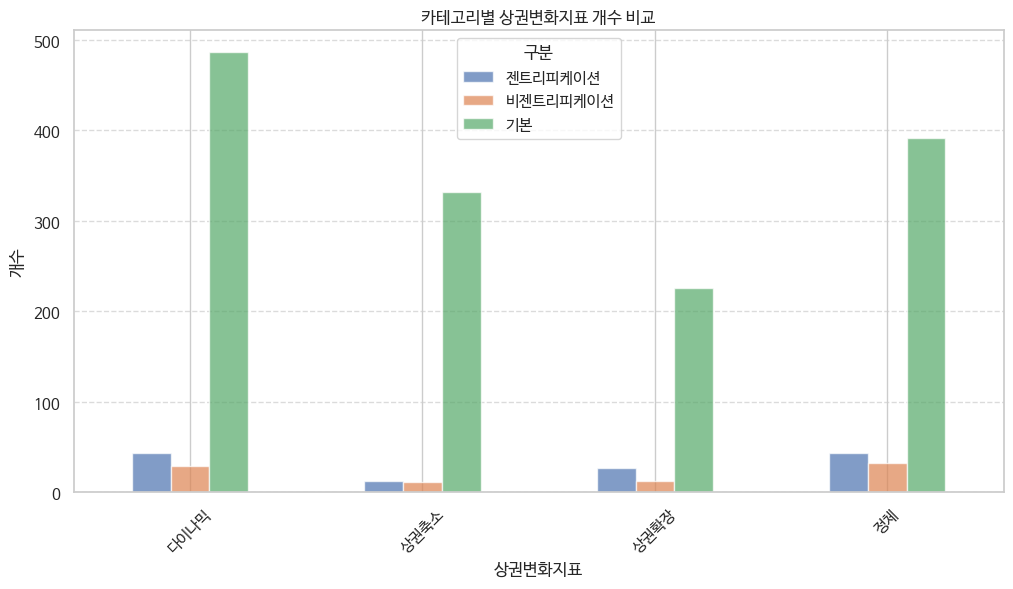

In [ ]:
plt.figure(figsize=(10, 6))
df_category_indicators.plot(kind='bar', figsize=(12, 6), alpha=0.7)
plt.title("카테고리별 상권변화지표 개수 비교")
plt.xlabel("상권변화지표")
plt.ylabel("개수")
plt.xticks(rotation=45)
plt.legend(title="구분")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 상권그룹 데이터 분석


In [89]:
df_bd_group_강남역.head()

,연도분기,상권구분코드,상권구분,상권코드,상권,상권변화지표코드,상권변화지표,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균,상권그룹,구분
0,20191,D,발달상권,3120187,신논현역,LL,다이나믹,80,42,93,48,강남역,비젠트리피케이션
1,20191,D,발달상권,3120189,강남역,LL,다이나믹,80,46,93,48,강남역,비젠트리피케이션
2,20191,D,발달상권,3120197,역삼역,LL,다이나믹,79,44,93,48,강남역,비젠트리피케이션
3,20193,A,골목상권,3110954,국기원,LL,다이나믹,47,34,92,48,강남역,비젠트리피케이션


### 기본통계분석


**젠트리피케이션 지역 vs 비젠트리피케이션 지역 비교 분석**

---

1. 운영 개월 수 비교

- 젠트리피케이션 지역

  - 운영 개월 수 평균이 대체로 높거나 변동성이 큼.
  - 종로3가 (151.8개월), 명동 (121.2개월), 대학로(혜화역) (105.1개월) 등은 운영 개월 수가 높음.
  - 하지만 홍대입구역 (74.4개월), 신사동 가로수길 (80.2개월), 성수동 (80.4개월) 등 일부 지역은 운영 기간이 짧음.
  - 운영 개월 수 편차가 커서, 오래 유지되는 곳과 빠르게 바뀌는 곳이 혼재되어 있음.

- 비젠트리피케이션 지역

  - 운영 개월 수 평균이 상대적으로 낮고, 변동성이 작음.
  - 영등포 (137.6개월), 동대문(DDP) (106.5개월) 등의 몇몇 지역은 운영 기간이 길지만,
  - 강남역 (71.5개월), 건대입구역 (91.4개월), 회기역 (95.1개월) 등은 상대적으로 짧음.
  - 운영 개월 수의 편차가 젠트리피케이션 지역보다 작고, 평균적으로도 더 낮음.
  - 즉, 비젠트리피케이션 지역은 운영 개월 수가 전반적으로 안정적인 편임.

- 결론
  - 젠트리피케이션 지역은 오래 지속되는 점포도 있지만, 폐업과 창업이 반복되는 지역도 많아 변동성이 큼.
  - 비젠트리피케이션 지역은 운영 개월 수가 비교적 짧거나 일정하게 유지되는 경향이 있음.

---

2. 폐업 영업 개월 수 비교

- 젠트리피케이션 지역

  - 종로3가 (70.6개월), 명동 (61.1개월) 등은 폐업까지 운영 기간이 길어, 한번 자리 잡으면 오래 유지되는 경향이 있음.
  - 하지만 신사동 가로수길 (46개월), 성수동 (52개월), 송리단길 (45.2개월) 등 일부 지역은 빠르게 교체되는 경향이 있음.

- 비젠트리피케이션 지역
  - 영등포 (62.1개월), 동대문(DDP) (64개월) 등 몇몇 지역은 운영 후 폐업까지 기간이 길지만,
  - 강남역 (41.5개월), 건대입구역 (46.1개월), 회기역 (48.6개월) 등은 운영 후 폐업까지 기간이 짧음.
- 결론
  - 둘의 차이가 유의미하게 있다고 보긴 어려움.
    - -> 분포나 변동성을 보는게 나을 듯함. (시각화)


In [ ]:
bd_group_list = [
    "기본", "명동", "신사동_가로수길", "문래",
    "북촌", "동대문(DDP)", "대학로(혜화역)", "종로3가",
    "회기역", "압구정로데오", "강남역", "송리단길",
    "여의도역", "영등포", "청담", "용리단길",
    "신림", "이수역", "서촌", "건대입구역",
    "성수동", "사당", "홍대입구역", "합정",
    "경리단길", "해방촌(이태원_근처)", "잠실역", "연남"
]

for bd_group in bd_group_list:
  print(f"상권그룹: {bd_group}")
  df_name = f"df_bd_group_{bd_group}"
  globals()[df_name]['운영영업개월평균'] = pd.to_numeric(globals()[df_name]['운영영업개월평균'], errors='coerce')
  globals()[df_name]['폐업영업개월평균'] = pd.to_numeric(globals()[df_name]['폐업영업개월평균'], errors='coerce')
  globals()[df_name]['서울운영영업개월평균'] = pd.to_numeric(globals()[df_name]['서울운영영업개월평균'], errors='coerce')
  globals()[df_name]['서울폐업영업개월평균'] = pd.to_numeric(globals()[df_name]['서울폐업영업개월평균'], errors='coerce')

  # 동적으로 변수에 접근
  if df_name in globals():
    display(globals()[df_name].describe())

  print("\n")

상권그룹: 기본


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,1436.000000,1436.000000,1436.000000,1436.000000
mean,96.715181,48.841226,94.093315,48.409471
std,21.781629,7.723163,3.891158,1.026218
min,27.000000,21.000000,92.000000,48.000000
25%,84.000000,44.000000,93.000000,48.000000
50%,93.000000,48.000000,93.000000,48.000000
75%,106.000000,52.000000,93.000000,48.000000
max,243.000000,110.000000,109.000000,52.000000




상권그룹: 명동


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,10.000000,10.000000,10.000000,10.000000
mean,123.700000,59.800000,95.300000,48.800000
std,17.600821,8.310636,5.121849,1.398412
min,98.000000,50.000000,92.000000,48.000000
25%,113.750000,54.250000,93.000000,48.000000
50%,123.000000,58.000000,93.000000,48.000000
75%,137.000000,63.000000,96.000000,49.500000
max,152.000000,79.000000,109.000000,52.000000




상권그룹: 신사동_가로수길


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,7.000000,7.000000,7.000000,7.0
mean,79.000000,45.857143,92.714286,48.0
std,6.928203,6.517376,0.487950,0.0
min,66.000000,36.000000,92.000000,48.0
25%,77.000000,44.000000,92.500000,48.0
50%,79.000000,46.000000,93.000000,48.0
75%,83.500000,46.500000,93.000000,48.0
max,87.000000,58.000000,93.000000,48.0




상권그룹: 문래


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,9.000000,9.000000,9.000000,9.000000
mean,98.555556,48.666667,93.111111,48.222222
std,19.040162,5.678908,0.781736,0.440959
min,73.000000,35.000000,92.000000,48.000000
25%,87.000000,49.000000,93.000000,48.000000
50%,108.000000,50.000000,93.000000,48.000000
75%,108.000000,51.000000,93.000000,48.000000
max,130.000000,56.000000,95.000000,49.000000




상권그룹: 북촌


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,6.000000,6.000000,6.0,6.000000
mean,96.333333,53.333333,93.0,48.166667
std,25.889509,6.801961,0.0,0.408248
min,63.000000,44.000000,93.0,48.000000
25%,81.500000,49.250000,93.0,48.000000
50%,91.500000,53.500000,93.0,48.000000
75%,114.250000,57.000000,93.0,48.000000
max,132.000000,63.000000,93.0,49.000000




상권그룹: 동대문(DDP)


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,23.000000,23.000000,23.000000,23.00000
mean,108.217391,63.782609,97.956522,49.26087
std,32.185480,11.595283,7.480145,1.86395
min,0.000000,44.000000,93.000000,48.00000
25%,100.000000,56.000000,93.000000,48.00000
50%,112.000000,62.000000,93.000000,48.00000
75%,126.500000,69.000000,109.000000,52.00000
max,152.000000,97.000000,109.000000,52.00000




상권그룹: 대학로(혜화역)


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,6.000000,6.000000,6.0,6.0
mean,90.166667,51.333333,93.0,48.0
std,20.566153,4.273952,0.0,0.0
min,51.000000,45.000000,93.0,48.0
25%,90.000000,49.500000,93.0,48.0
50%,94.000000,51.000000,93.0,48.0
75%,101.750000,54.000000,93.0,48.0
max,109.000000,57.000000,93.0,48.0




상권그룹: 종로3가


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,12.000000,12.000000,12.000000,12.000000
mean,152.250000,71.500000,98.416667,49.416667
std,30.286886,11.164066,7.821396,1.928652
min,110.000000,54.000000,93.000000,48.000000
25%,122.750000,60.750000,93.000000,48.000000
50%,160.000000,72.000000,93.000000,48.000000
75%,173.500000,78.500000,109.000000,52.000000
max,194.000000,89.000000,109.000000,52.000000




상권그룹: 회기역


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,11.000000,11.000000,11.000000,11.000000
mean,96.272727,46.909091,97.818182,49.272727
std,10.159635,3.048099,7.332369,1.848833
min,81.000000,42.000000,93.000000,48.000000
25%,90.500000,44.000000,93.000000,48.000000
50%,96.000000,47.000000,93.000000,48.000000
75%,102.000000,49.000000,103.500000,51.000000
max,115.000000,51.000000,109.000000,52.000000




상권그룹: 압구정로데오


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,7.000000,7.000000,7.0,7.0
mean,95.000000,46.285714,93.0,48.0
std,11.090537,5.794086,0.0,0.0
min,84.000000,38.000000,93.0,48.0
25%,91.000000,44.000000,93.0,48.0
50%,93.000000,46.000000,93.0,48.0
75%,93.500000,47.500000,93.0,48.0
max,119.000000,57.000000,93.0,48.0




상권그룹: 강남역


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,4.000000,4.000000,4.00,4.0
mean,71.500000,41.500000,92.75,48.0
std,16.340135,5.259911,0.50,0.0
min,47.000000,34.000000,92.00,48.0
25%,71.000000,40.000000,92.75,48.0
50%,79.500000,43.000000,93.00,48.0
75%,80.000000,44.500000,93.00,48.0
max,80.000000,46.000000,93.00,48.0




상권그룹: 송리단길


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,7.000000,7.000000,7.0,7.0
mean,88.571429,44.714286,93.0,48.0
std,12.778330,2.360387,0.0,0.0
min,71.000000,41.000000,93.0,48.0
25%,81.000000,43.500000,93.0,48.0
50%,85.000000,45.000000,93.0,48.0
75%,97.500000,46.000000,93.0,48.0
max,107.000000,48.000000,93.0,48.0




상권그룹: 여의도역


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,1.0,1.0,1.0,1.0
mean,103.0,48.0,93.0,48.0
std,NaN,NaN,NaN,NaN
min,103.0,48.0,93.0,48.0
25%,103.0,48.0,93.0,48.0
50%,103.0,48.0,93.0,48.0
75%,103.0,48.0,93.0,48.0
max,103.0,48.0,93.0,48.0




상권그룹: 영등포


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,17.000000,17.000000,17.000000,17.000000
mean,123.000000,57.411765,93.176471,48.117647
std,49.633658,11.667577,0.528594,0.332106
min,58.000000,44.000000,93.000000,48.000000
25%,91.000000,50.000000,93.000000,48.000000
50%,104.000000,56.000000,93.000000,48.000000
75%,142.000000,65.000000,93.000000,48.000000
max,262.000000,89.000000,95.000000,49.000000




상권그룹: 청담


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,6.000000,6.000000,6.000000,6.000000
mean,78.000000,43.166667,93.666667,48.333333
std,12.393547,4.956477,1.632993,0.816497
min,66.000000,37.000000,93.000000,48.000000
25%,68.000000,39.250000,93.000000,48.000000
50%,76.000000,43.500000,93.000000,48.000000
75%,85.500000,47.000000,93.000000,48.000000
max,96.000000,49.000000,97.000000,50.000000




상권그룹: 용리단길


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,3.000000,3.000000,3.0,3.0
mean,89.333333,53.000000,93.0,48.0
std,18.770544,2.645751,0.0,0.0
min,69.000000,51.000000,93.0,48.0
25%,81.000000,51.500000,93.0,48.0
50%,93.000000,52.000000,93.0,48.0
75%,99.500000,54.000000,93.0,48.0
max,106.000000,56.000000,93.0,48.0




상권그룹: 신림


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,13.000000,13.000000,13.000000,13.000000
mean,92.846154,46.153846,92.769231,48.153846
std,22.729739,5.683986,0.438529,0.375534
min,61.000000,38.000000,92.000000,48.000000
25%,84.000000,43.000000,93.000000,48.000000
50%,88.000000,45.000000,93.000000,48.000000
75%,94.000000,49.000000,93.000000,48.000000
max,147.000000,56.000000,93.000000,49.000000




상권그룹: 이수역


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,9.000000,9.000000,9.000000,9.000000
mean,94.666667,48.222222,92.888889,48.222222
std,12.599603,3.032234,0.600925,0.440959
min,73.000000,45.000000,92.000000,48.000000
25%,89.000000,47.000000,93.000000,48.000000
50%,100.000000,47.000000,93.000000,48.000000
75%,103.000000,49.000000,93.000000,48.000000
max,108.000000,54.000000,94.000000,49.000000




상권그룹: 서촌


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,8.000000,8.000000,8.000000,8.000000
mean,100.000000,53.625000,97.000000,49.125000
std,25.145292,5.069164,7.406561,1.807722
min,60.000000,45.000000,93.000000,48.000000
25%,88.500000,51.250000,93.000000,48.000000
50%,98.500000,53.500000,93.000000,48.000000
75%,110.500000,57.500000,97.000000,49.750000
max,143.000000,60.000000,109.000000,52.000000




상권그룹: 건대입구역


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,9.000000,9.000000,9.000000,9.0
mean,88.111111,45.444444,92.888889,48.0
std,16.788720,2.185813,0.333333,0.0
min,71.000000,42.000000,92.000000,48.0
25%,76.000000,44.000000,93.000000,48.0
50%,88.000000,46.000000,93.000000,48.0
75%,95.000000,47.000000,93.000000,48.0
max,124.000000,49.000000,93.000000,48.0




상권그룹: 성수동


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,7.000000,7.000000,7.000000,7.0
mean,80.857143,49.142857,92.857143,48.0
std,12.375090,2.911390,0.377964,0.0
min,70.000000,47.000000,92.000000,48.0
25%,73.000000,47.000000,93.000000,48.0
50%,75.000000,47.000000,93.000000,48.0
75%,86.000000,51.000000,93.000000,48.0
max,103.000000,54.000000,93.000000,48.0




상권그룹: 사당


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,7.000000,7.000000,7.000000,7.000000
mean,92.714286,46.571429,93.714286,48.571429
std,11.842217,4.429339,1.253566,0.786796
min,77.000000,39.000000,93.000000,48.000000
25%,86.000000,44.000000,93.000000,48.000000
50%,88.000000,48.000000,93.000000,48.000000
75%,100.000000,50.000000,94.000000,49.000000
max,112.000000,51.000000,96.000000,50.000000




상권그룹: 홍대입구역


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,12.000000,12.000000,12.000000,12.000000
mean,71.083333,43.250000,96.000000,49.000000
std,12.486053,5.785955,6.120012,1.477098
min,52.000000,32.000000,93.000000,48.000000
25%,63.250000,40.500000,93.000000,48.000000
50%,72.500000,44.500000,93.000000,48.500000
75%,79.000000,47.250000,95.000000,49.000000
max,96.000000,51.000000,109.000000,52.000000




상권그룹: 합정


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,6.000000,6.000000,6.000000,6.000000
mean,77.333333,47.833333,92.833333,48.333333
std,14.935417,2.786874,0.408248,0.516398
min,57.000000,43.000000,92.000000,48.000000
25%,71.000000,47.250000,93.000000,48.000000
50%,75.000000,48.000000,93.000000,48.000000
75%,83.500000,49.500000,93.000000,48.750000
max,101.000000,51.000000,93.000000,49.000000




상권그룹: 경리단길


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,3.00000,3.000000,3.000000,3.000000
mean,98.00000,54.333333,98.333333,49.333333
std,7.81025,2.886751,9.237604,2.309401
min,89.00000,51.000000,93.000000,48.000000
25%,95.50000,53.500000,93.000000,48.000000
50%,102.00000,56.000000,93.000000,48.000000
75%,102.50000,56.000000,101.000000,50.000000
max,103.00000,56.000000,109.000000,52.000000




상권그룹: 해방촌(이태원_근처)


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,5.000000,5.000000,5.000000,5.000000
mean,76.000000,46.000000,95.000000,48.800000
std,10.977249,2.915476,4.472136,1.788854
min,63.000000,44.000000,93.000000,48.000000
25%,69.000000,44.000000,93.000000,48.000000
50%,74.000000,45.000000,93.000000,48.000000
75%,84.000000,46.000000,93.000000,48.000000
max,90.000000,51.000000,103.000000,52.000000




상권그룹: 잠실역


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,2.000000,2.000000,2.000000,2.000000
mean,84.000000,53.500000,100.500000,50.000000
std,14.142136,3.535534,12.020815,2.828427
min,74.000000,51.000000,92.000000,48.000000
25%,79.000000,52.250000,96.250000,49.000000
50%,84.000000,53.500000,100.500000,50.000000
75%,89.000000,54.750000,104.750000,51.000000
max,94.000000,56.000000,109.000000,52.000000




상권그룹: 연남


,운영영업개월평균,폐업영업개월평균,서울운영영업개월평균,서울폐업영업개월평균
count,4.000000,4.000000,4.000000,4.000000
mean,92.250000,53.000000,96.750000,49.250000
std,21.700614,6.324555,8.180261,1.892969
min,72.000000,47.000000,92.000000,48.000000
25%,82.500000,48.500000,92.750000,48.000000
50%,87.000000,52.000000,93.000000,48.500000
75%,96.750000,56.500000,97.000000,49.750000
max,123.000000,61.000000,109.000000,52.000000


### 운영개월수평균 (가장 오래 유지되는 지역 vs. 가장 짧게 유지되는 지역) 비교 분석


운영 개월 수가 가장 오래 유지되는 지역 (TOP 10)

- 운영 개월 수가 가장 길게 유지되는 지역:

  - 종로3가 (약 150개월), 명동 (약 140개월), 영등포 (약 130개월) 등 운영 개월 수가 매우 긴 지역 포함.
  - 사당, 동대문(DDP), 대학로(혜화역), 연남, 서촌, 여의도역 등도 100개월 이상 운영되는 경향.

- 젠트리피케이션 지역: 종로3가, 명동, 대학로(혜화역), 연남, 서촌
- 비젠트리피케이션 지역: 영등포, 동대문(DDP), 사당, 여의도역

운영 개월 수가 가장 짧게 유지되는 지역 (BOTTOM 10)

- 운영 개월 수가 가장 짧게 유지되는 지역:

  - 송리단길, 건대입구역, 해방촌(이태원 근처), 청담, 합정, 잠실역, 성수동, 신사동 가로수길, 홍대입구역, 강남역 등이 포함됨.
  - 운영 개월 수가 90개월 이하로 짧으며, 특히 송리단길, 건대입구역, 해방촌(이태원 근처) 등은 약 80개월 내외로 운영됨.

- 젠트리피케이션 지역: 송리단길, 해방촌(이태원 근처), 합정, 성수동, 신사동 가로수길, 홍대입구역
- 비젠트리피케이션 지역: 건대입구역, 청담, 잠실역, 강남역

---

젠트리피케이션 지역 vs. 비젠트리피케이션 지역 운영 개월 수 비교

- 젠트리피케이션 지역

  - 운영 개월 수가 짧은 지역 다수 포함됨.
  - 송리단길, 해방촌(이태원 근처), 합정, 성수동, 신사동 가로수길, 홍대입구역 등 운영 개월 수가 짧음.
  - 일부 예외적으로 운영 개월 수가 긴 지역(예: 종로3가, 명동, 대학로(혜화역))이 있지만, 대체로 운영 개월 수가 짧고 변동성이 큼.

- 비젠트리피케이션 지역
  - 운영 개월 수가 긴 지역과 짧은 지역이 혼재됨.
  - 운영 개월 수가 긴 지역: 영등포, 동대문(DDP), 사당, 여의도역 등 운영 개월 수가 100개월 이상으로 안정적.
  - 운영 개월 수가 짧은 지역: 강남역, 청담, 잠실역 등은 짧게 유지됨.
  - 상대적으로 운영 개월 수가 일정하게 유지되는 경향이 있지만, 일부 변화가 빠른 지역도 포함됨.

결론

- 젠트리피케이션 지역은 운영 개월 수가 짧은 지역이 많으며, 빠른 상권 변화와 창업-폐업이 반복되는 특징을 보임.
- 종로3가, 명동 등 일부 지역은 오래 유지되지만 전반적으로 운영 개월 수가 짧은 경향이 강함.
- 비젠트리피케이션 지역은 운영 개월 수가 비교적 안정적인 경향을 보임.
- 특히 영등포, 동대문(DDP), 여의도역, 사당 등은 운영 개월 수가 길어 안정성이 높음.
- 하지만 강남역, 청담, 잠실역 등 일부 지역은 운영 개월 수가 짧아 빠르게 변화하는 상권이 혼재됨.


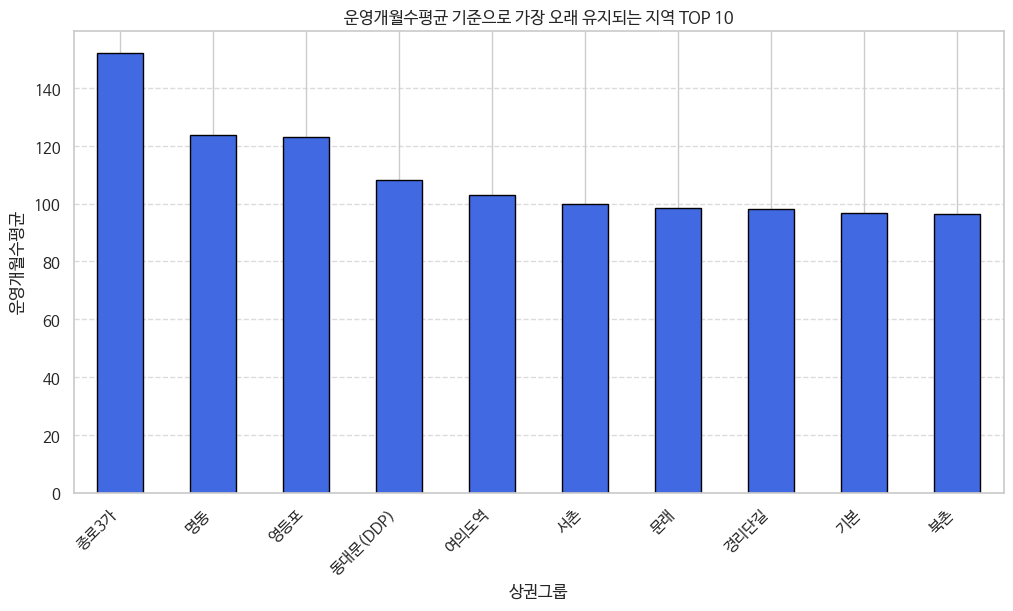

In [104]:
# 운영 개월 수 기준으로 가장 오래 유지되는 지역 TOP 10
top_10_operating = df_dong_indicators.groupby("상권그룹")["운영영업개월평균"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_10_operating.plot(kind='bar', color='royalblue', edgecolor='black')
plt.xlabel("상권그룹")
plt.ylabel("운영개월수평균")
plt.title("운영개월수평균 기준으로 가장 오래 유지되는 지역 TOP 10")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

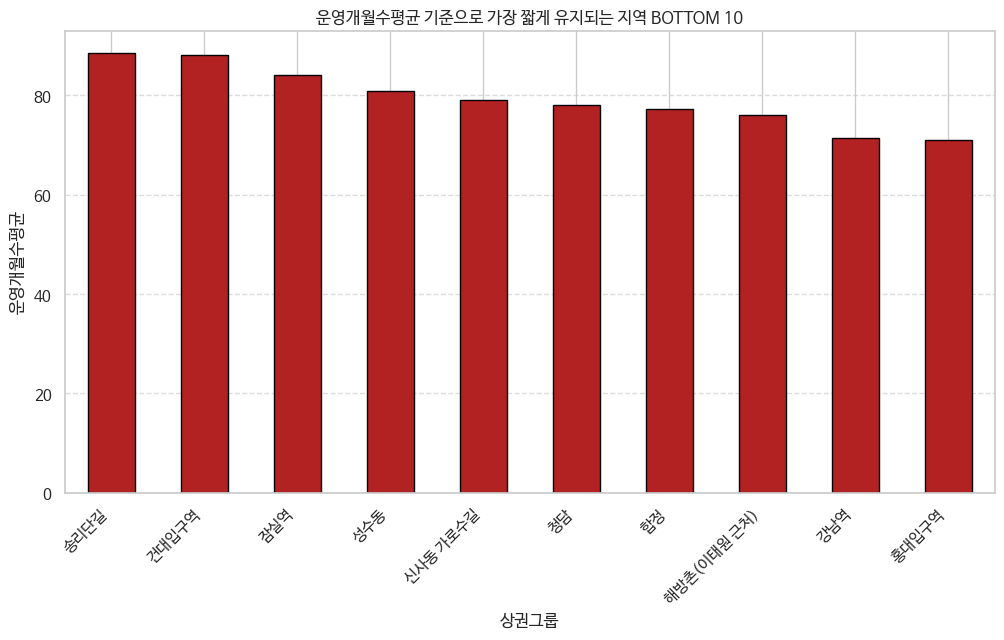

In [105]:
# 운영 개월 수 기준으로 가장 짧게 유지되는 지역 BOTTOM 10
top_10_operating = df_dong_indicators.groupby("상권그룹")["운영영업개월평균"].mean().sort_values(ascending=False).tail(10)

plt.figure(figsize=(12, 6))
top_10_operating.plot(kind='bar', color='firebrick', edgecolor='black')
plt.xlabel("상권그룹")
plt.ylabel("운영개월수평균")
plt.title("운영개월수평균 기준으로 가장 짧게 유지되는 지역 BOTTOM 10")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 폐업개월수평균 (가장 오래 운영 후 폐업하는 지역 vs. 가장 짧게 운영 후 폐업하는 지역) 비교 분석


폐업 개월 수가 가장 오래 운영 후 폐업하는 지역 (TOP 10)

- 폐업 개월 수가 가장 긴 지역:

  - 종로3가 (약 70개월), 동대문(DDP) (약 65개월), 영등포 (약 63개월)
  - 명동, 경리단길, 북촌, 연남, 대학로(혜화역), 잠실역, 용리단길 등도 폐업 개월 수가 50개월 이상 유지됨.

- 젠트리피케이션 지역: 종로3가, 명동, 경리단길, 북촌, 연남, 대학로(혜화역)
- 비젠트리피케이션 지역: 동대문(DDP), 영등포, 잠실역, 용리단길

폐업 개월 수가 가장 짧게 운영 후 폐업하는 지역 (BOTTOM 10)

- 폐업 개월 수가 가장 짧은 지역:

  - 회기역, 여의도역, 청담, 신림, 압구정로데오, 건대입구역, 신사동 가로수길, 송리단길, 홍대입구역, 강남역
  - 폐업 개월 수가 약 40~50개월 수준으로, 비교적 빠르게 폐업하는 경향

- 젠트리피케이션 지역: 신사동 가로수길, 송리단길, 홍대입구역
- 비젠트리피케이션 지역: 회기역, 여의도역, 청담, 신림, 압구정로데오, 건대입구역, 강남역

---

**결론**

- 젠트리피케이션 지역은 폐업 개월 수가 짧은 지역이 많아 빠른 상권 변화와 창업-폐업이 반복되는 특징을 보임.
- 그러나 일부 지역(종로3가, 명동, 경리단길 등)은 폐업 개월 수가 길어 예외적인 패턴을 가짐.
- 비젠트리피케이션 지역은 폐업 개월 수가 비교적 일정하게 유지되는 경향이 강함.
- 특히 영등포, 동대문(DDP) 등은 폐업 개월 수가 길어 안정성이 높음.
- 하지만 강남역, 여의도역, 건대입구역 등 일부 지역은 폐업 개월 수가 짧아 젠트리피케이션 지역과 유사한 변동성을 보일 수 있음.


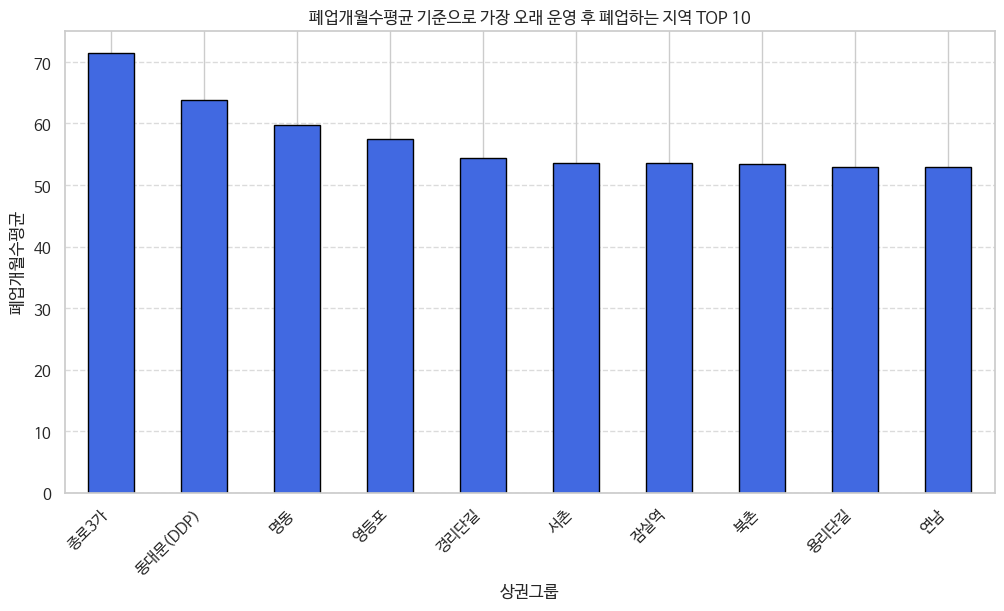

In [106]:
# 폐업 개월 수 기준으로 가장 오래 운영 후 폐업하는 지역 TOP 10
top_10_closing = df_dong_indicators.groupby("상권그룹")["폐업영업개월평균"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_10_closing.plot(kind='bar', color='royalblue', edgecolor='black')
plt.xlabel("상권그룹")
plt.ylabel("폐업개월수평균")
plt.title("폐업개월수평균 기준으로 가장 오래 운영 후 폐업하는 지역 TOP 10")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

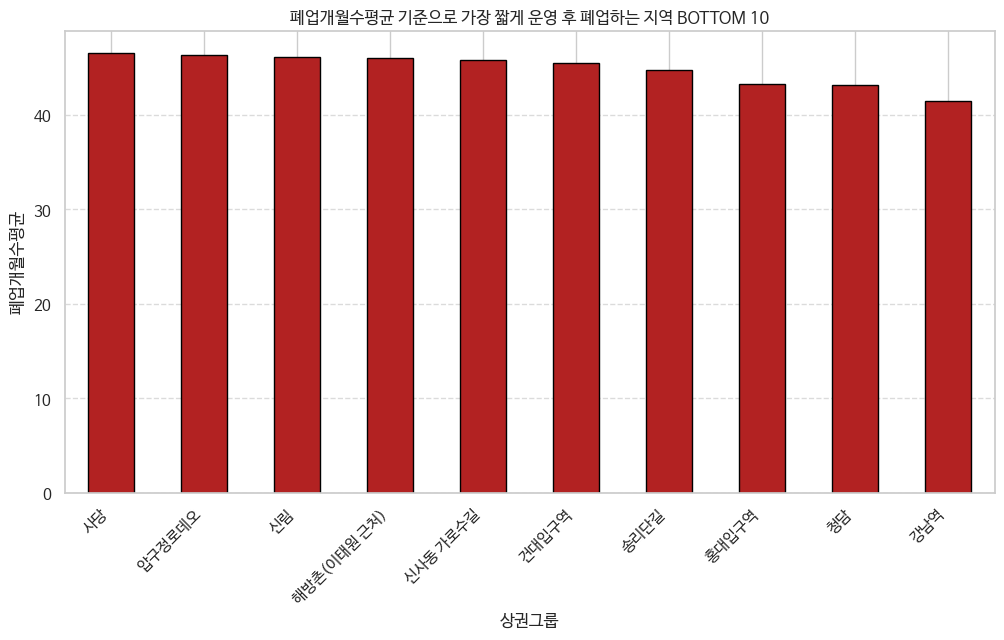

In [107]:
# 폐업 개월 수 기준으로 가장 짧게 운영 후 폐업하는 지역 BOTTOM 10
top_10_closing = df_dong_indicators.groupby("상권그룹")["폐업영업개월평균"].mean().sort_values(ascending=False).tail(10)

plt.figure(figsize=(12, 6))
top_10_closing.plot(kind='bar', color='firebrick', edgecolor='black')
plt.xlabel("상권그룹")
plt.ylabel("폐업개월수평균")
plt.title("폐업개월수평균 기준으로 가장 짧게 운영 후 폐업하는 지역 BOTTOM 10")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 폐업영업개월수평균 분포 분석 (젠/비젠 데이터프레임 사용)


젠트리피케이션 지역의 폐업 영업 개월 수 분석

- 대체로 폐업 개월 수가 짧거나 변동성이 큼.
- 홍대입구역, 신림, 해방촌(이태원 근처), 송리단길 등은 폐업 개월 수가 40~50개월 사이로 짧은 편.
- 하지만, 종로3가, 명동, 북촌 등의 지역은 60개월 이상 유지되는 사례도 있어, 일부 지역에서 상대적으로 오래 운영되는 경향이 나타냄.
- 특정 지역에서는 폐업 개월 수가 고르게 분포되지 않고 특정 값에 집중되는 경향이 있으며, 이는 급격한 변동성을 의미할 가능성이 높음.

비젠트리피케이션 지역의 폐업 영업 개월 수 분석

- 전반적으로 젠트리피케이션 지역보다 폐업 개월 수가 길거나, 일정한 패턴을 보임.
- 영등포, 동대문(DDP), 여의도역 등은 50개월 이상 유지되는 사례가 많으며, 일부 지역에서는 60~100개월까지 유지되는 경우도 존재함.
- 강남역, 청담, 건대입구역, 압구정로데오 등 일부 지역에서는 폐업 개월 수가 40~50개월 수준으로 짧은 곳도 존재하지만, 젠트리피케이션 지역보다 폐업 개월 수가 일정한 분포를 유지하는 경향이 강한. .

---

젠트리피케이션 vs. 비젠트리피케이션 비교

- 젠트리피케이션 지역

  - 폐업 개월 수가 짧거나 변동성이 큼.
  - 특정 지역(종로3가, 명동 등)은 예외적으로 길게 유지되지만, 전반적으로 짧은 주기로 창업과 폐업이 반복됨.

- 비젠트리피케이션 지역
  - 폐업 개월 수가 상대적으로 길고 일정한 패턴을 보임.
  - 일부 지역(강남역, 청담 등)은 짧지만, 대체로 60개월 이상 유지되는 지역이 많음.

**결론**

- 젠트리피케이션 지역은 폐업 개월 수가 짧고 변동성이 크며, 상권이 빠르게 변화하는 특징이 있음.
- 창업과 폐업이 빈번하며, 특정 지역에서는 상권이 지속되기도 하지만 대부분의 지역에서는 짧은 운영 후 폐업하는 패턴이 두드러짐.
- 비젠트리피케이션 지역은 폐업 개월 수가 상대적으로 길거나 일정한 패턴을 보임.
- 특히 영등포, 동대문(DDP) 등의 지역은 장기간 운영되는 점포 비율이 높아 상대적으로 안정적인 특성을 나타냄.


In [ ]:
gen_list = [
    '대학로(혜화역)', '북촌', '서촌', '홍대입구역',
    '합정', '연남', '해방촌(이태원_근처)', '경리단길',
    '종로3가', '성수동', '신사동_가로수길', '송리단길',
    '명동', '신림', '문래', '이수역', '용리단길'
]

non_gen_list = [
    '강남역', '압구정로데오', '건대입구역', '여의도역', '동대문(DDP)',
    '잠실역', '회기역', '영등포', '청담', '사당'
]

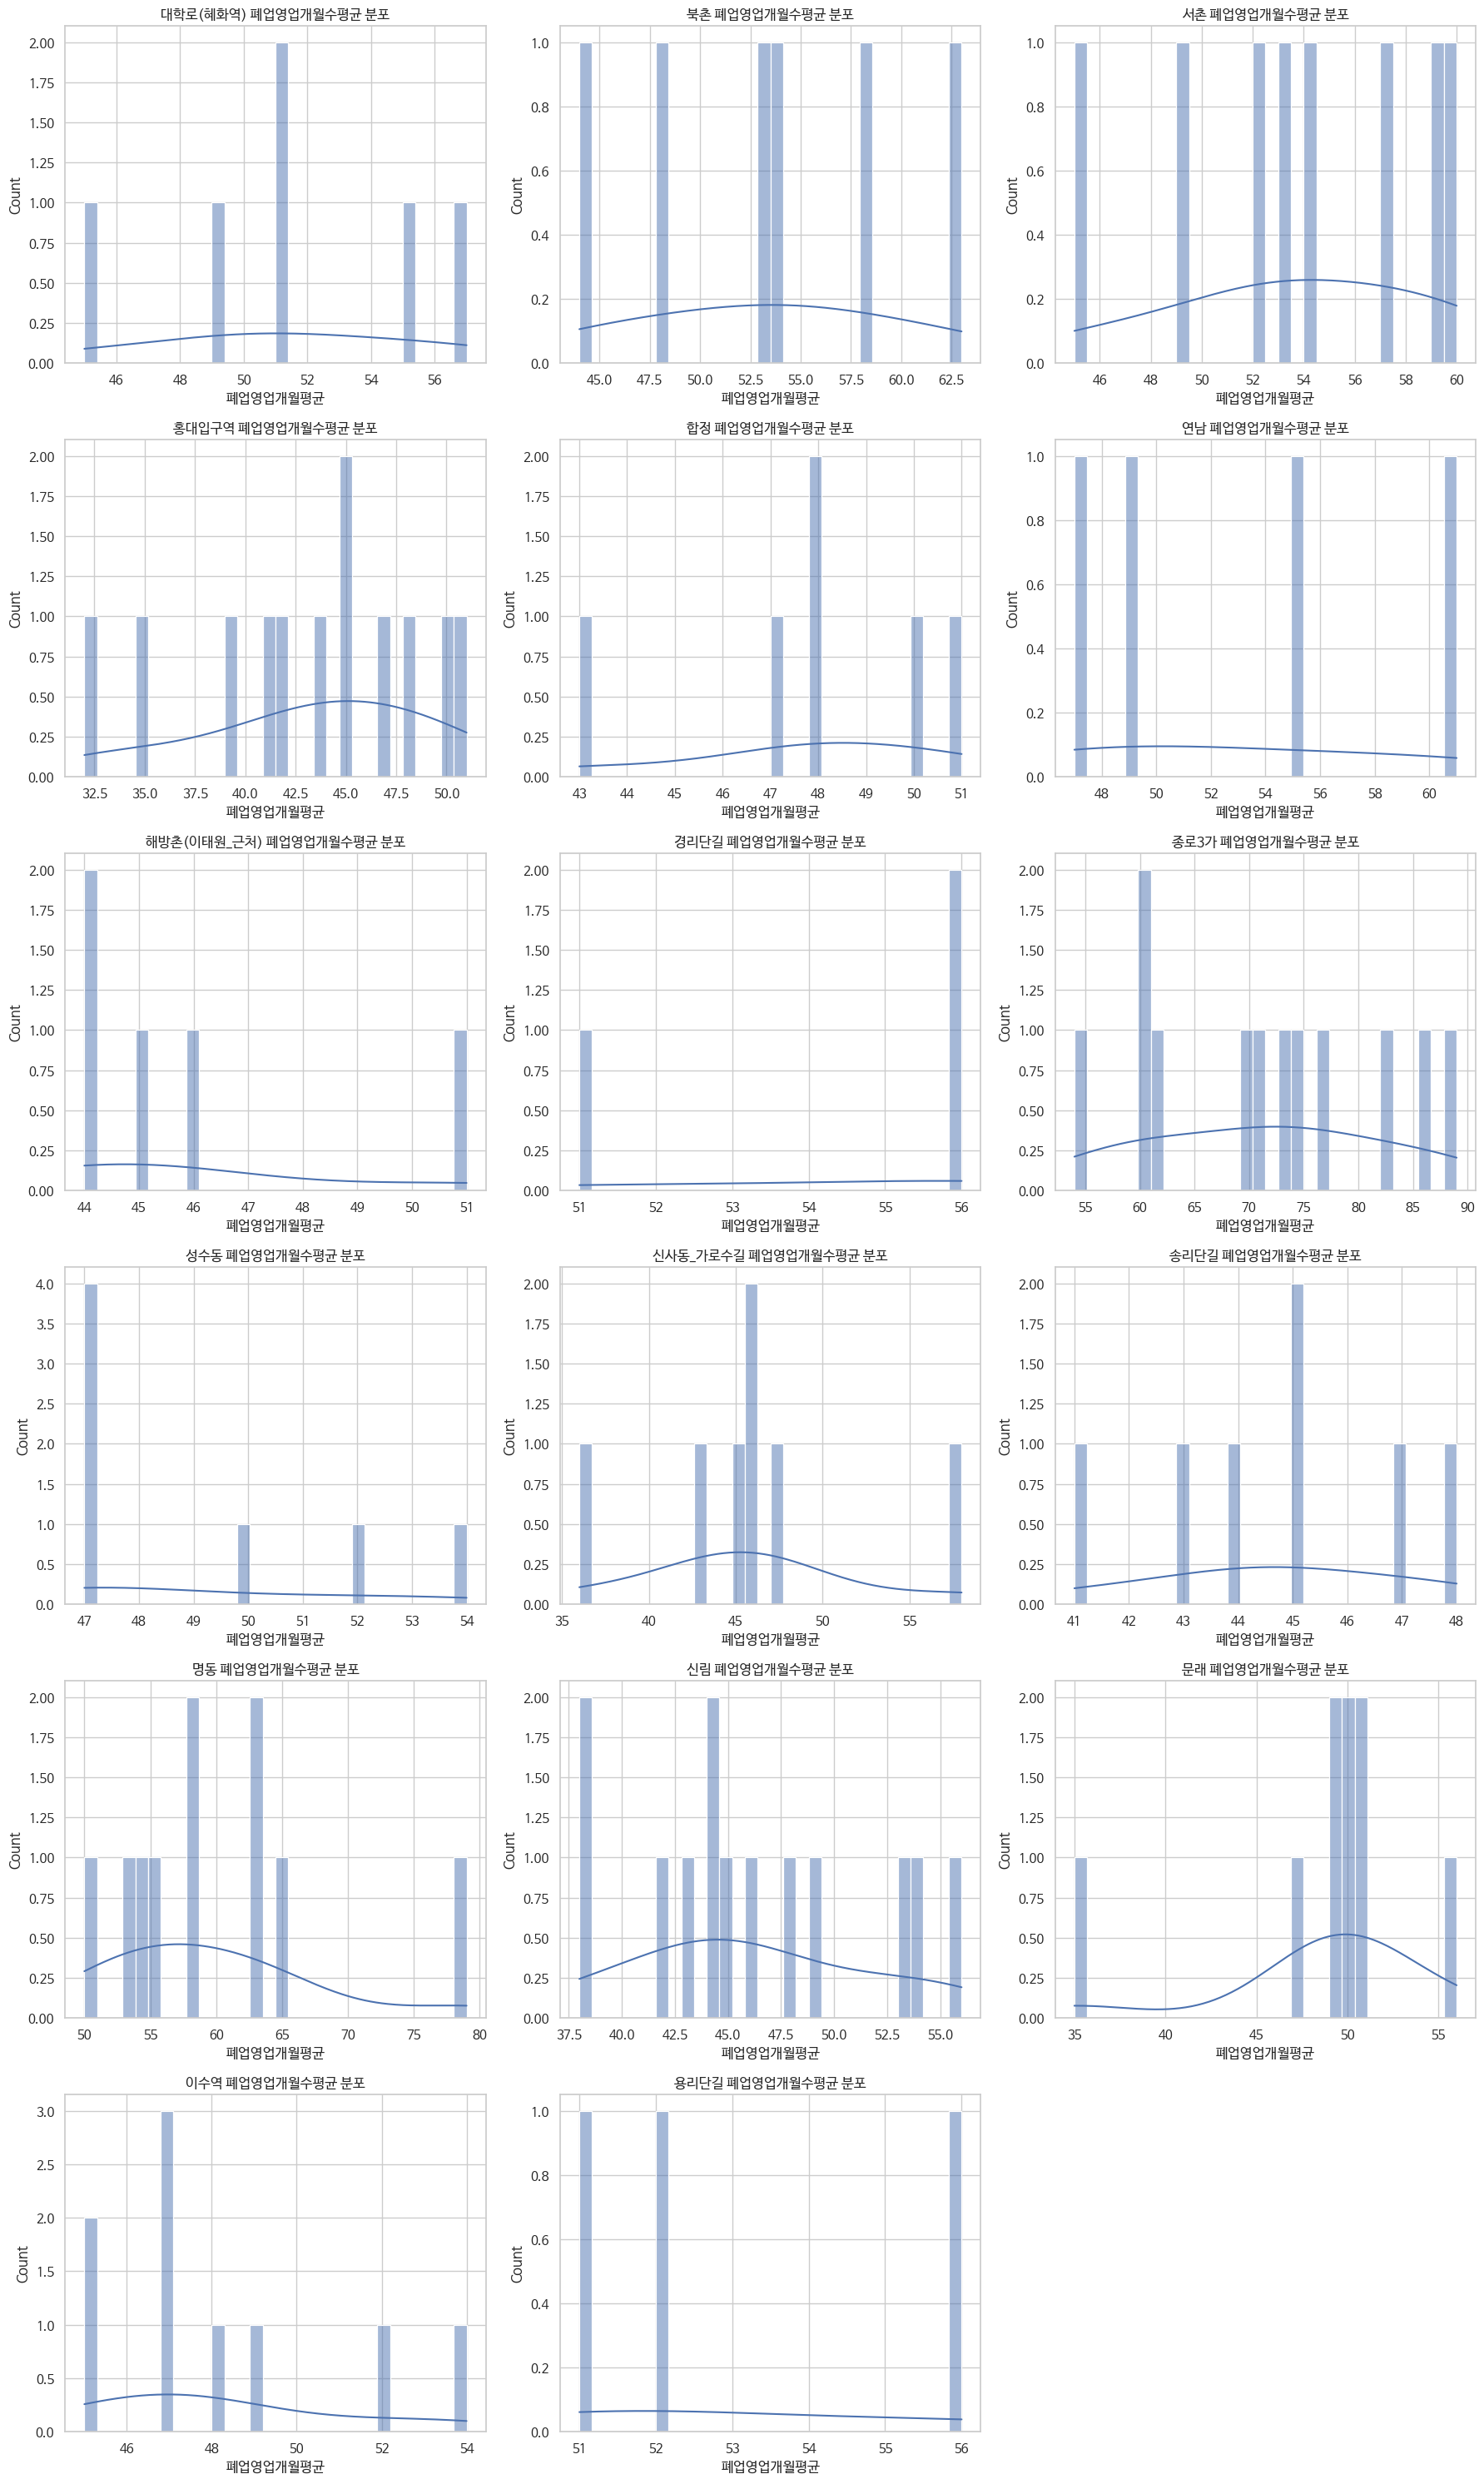

In [ ]:
# 젠트리피케이션 지역 데이터프레임 데이터 타입 변환
for gen in gen_list:
  df_name = f"df_bd_group_{gen}"
  if df_name in globals():
    globals()[df_name]['운영영업개월평균'] = pd.to_numeric(globals()[df_name]['운영영업개월평균'], errors='coerce')
    globals()[df_name]['폐업영업개월평균'] = pd.to_numeric(globals()[df_name]['폐업영업개월평균'], errors='coerce')
    globals()[df_name]['서울운영영업개월평균'] = pd.to_numeric(globals()[df_name]['서울운영영업개월평균'], errors='coerce')
    globals()[df_name]['서울폐업영업개월평균'] = pd.to_numeric(globals()[df_name]['서울폐업영업개월평균'], errors='coerce')

# 폐업 영업 개월 수 분포 시각화 (젠트리피케이션 지역)
num_cols = 3
num_rows_gen = -(-len(gen_list) // num_cols)  # 올림 나눗셈
fig, axes = plt.subplots(num_rows_gen, num_cols, figsize=(18, 5 * num_rows_gen))
axes = axes.flatten()

for i, gen in enumerate(gen_list):
  if i < len(axes):  # 축의 개수보다 지역이 적을 경우를 대비
    df_name = f"df_bd_group_{gen}"
    if df_name in globals():
      sns.histplot(globals()[df_name]["폐업영업개월평균"].dropna(), bins=30, kde=True, ax=axes[i])
      axes[i].set_title(f"{gen} 폐업영업개월수평균 분포")
      axes[i].set_xlabel("폐업영업개월평균")
      axes[i].set_ylabel("Count")
    else:
      axes[i].text(0.5, 0.5, f"데이터 없음: {gen}", horizontalalignment='center', verticalalignment='center')
      axes[i].set_title(f"{gen} (데이터 없음)")

# 남은 축 처리
for i in range(len(gen_list), len(axes)):
  fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

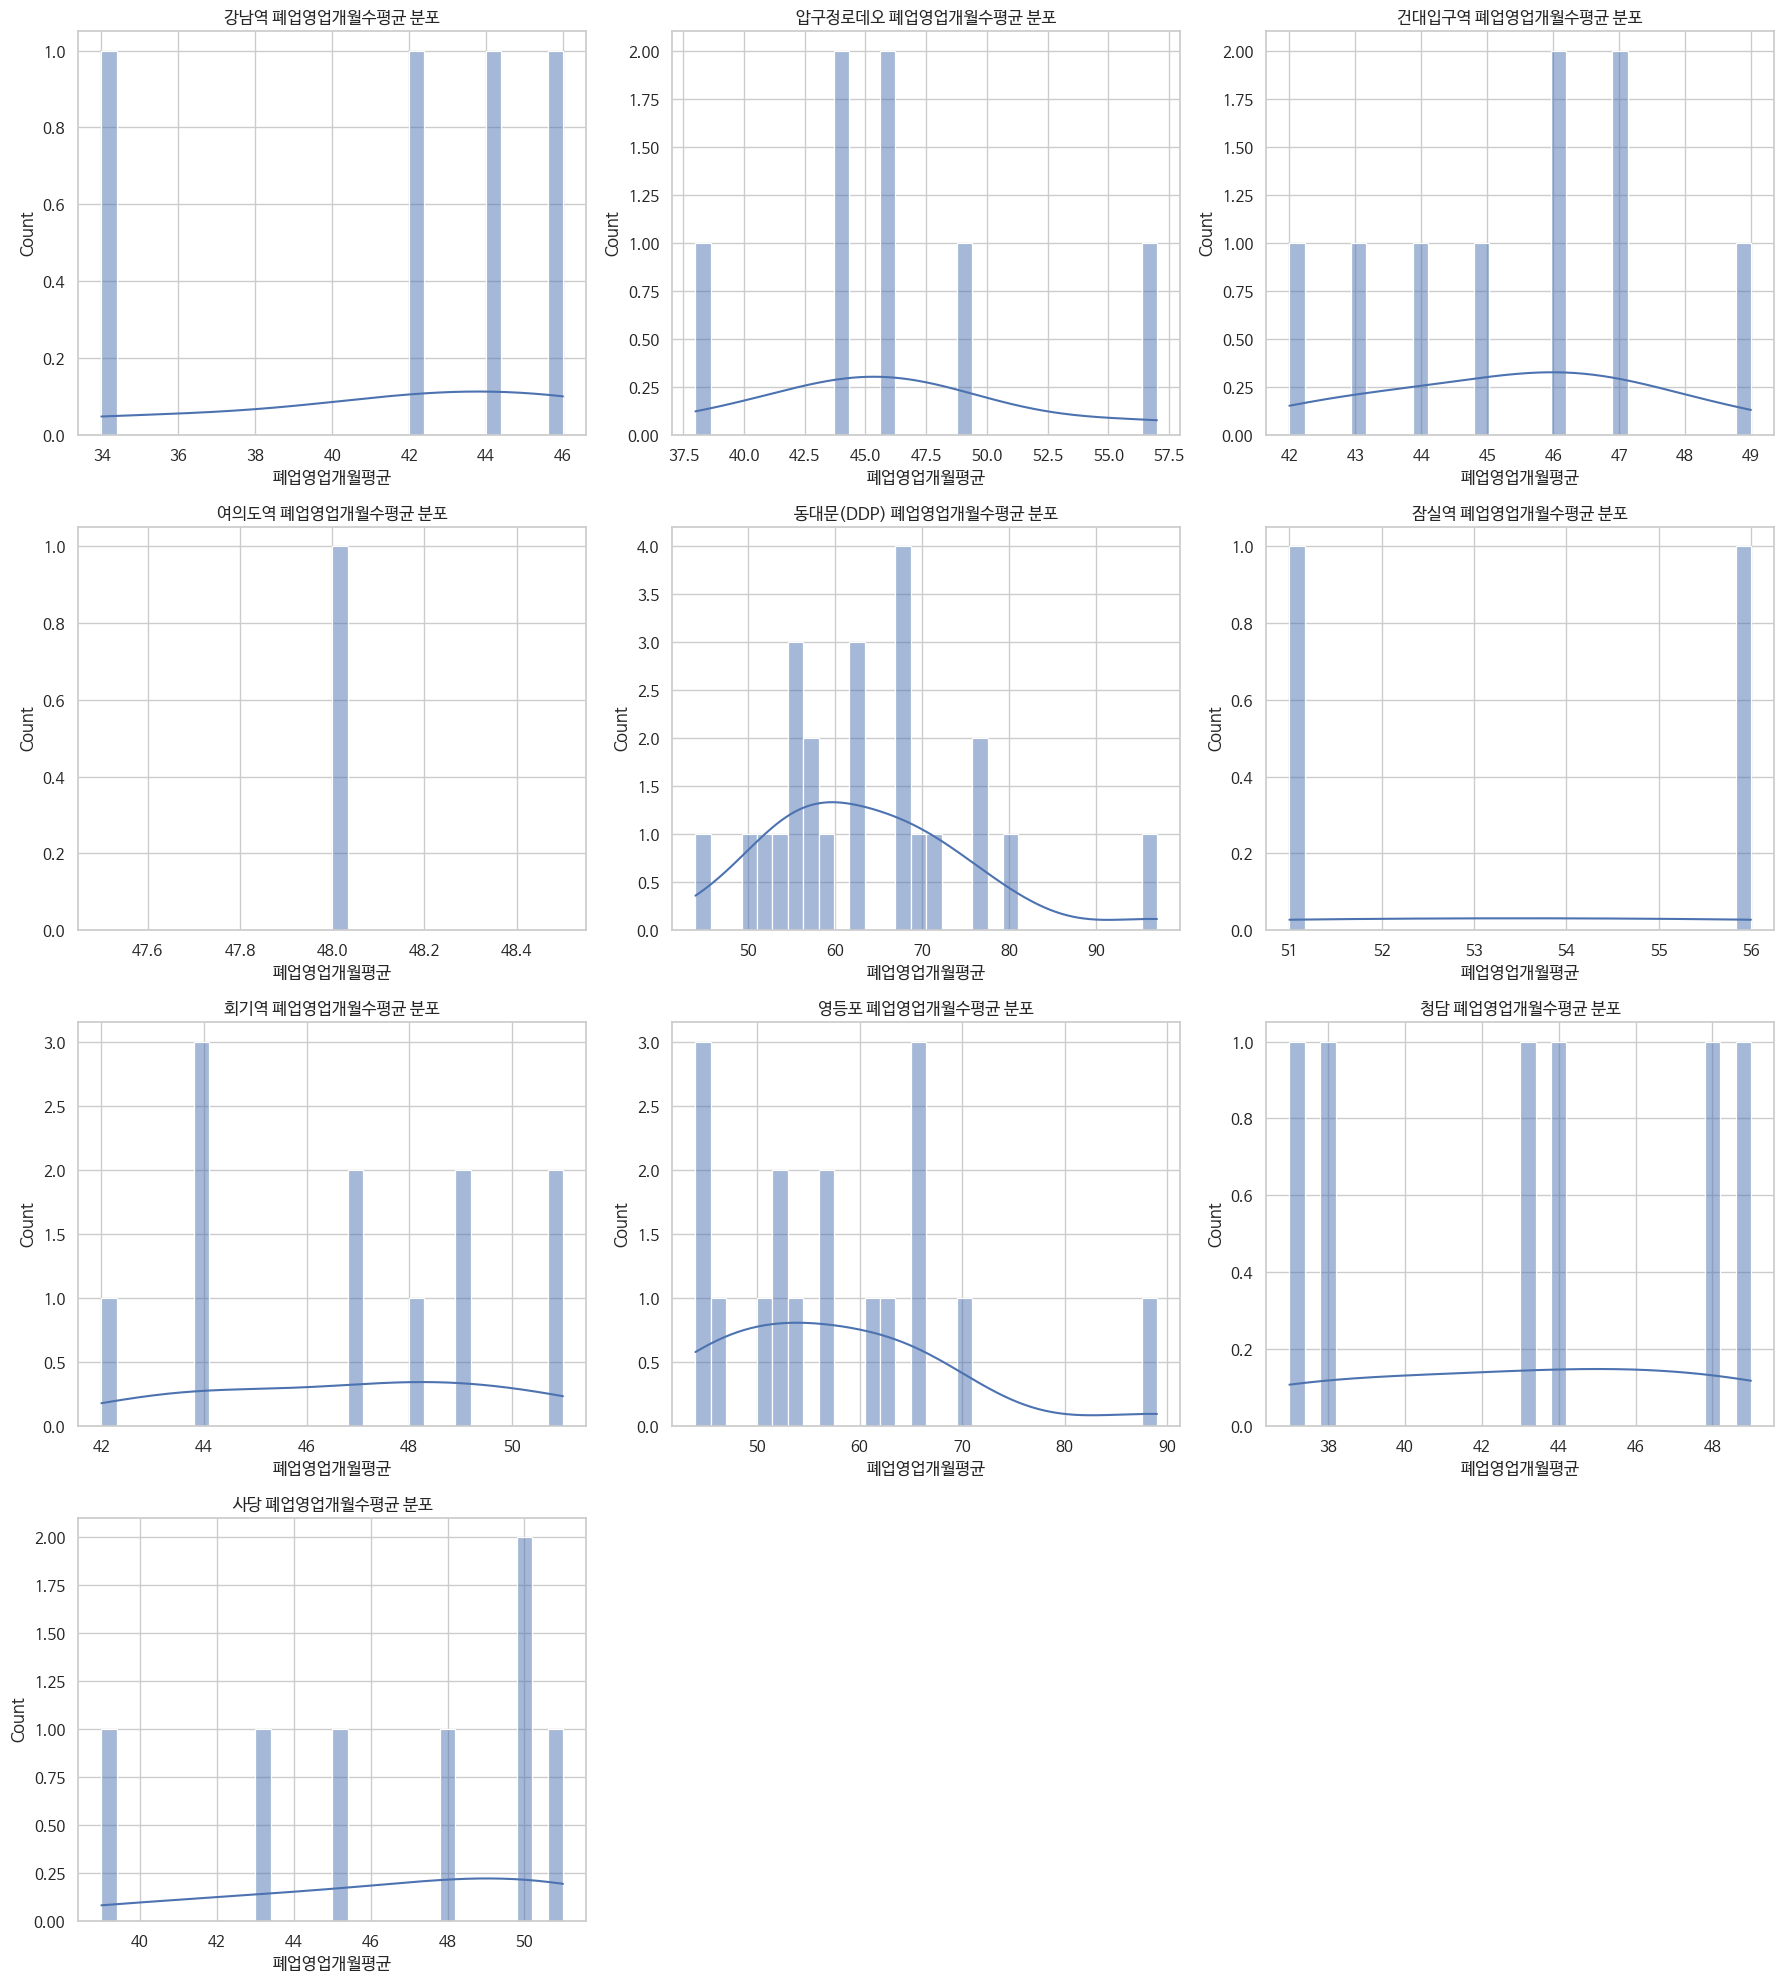

In [ ]:
# 비젠트리피케이션 지역 데이터프레임 데이터 타입 변환
for non_gen in non_gen_list:
  df_name = f"df_bd_group_{non_gen}"
  if df_name in globals():
    globals()[df_name]['운영영업개월평균'] = pd.to_numeric(globals()[df_name]['운영영업개월평균'], errors='coerce')
    globals()[df_name]['폐업영업개월평균'] = pd.to_numeric(globals()[df_name]['폐업영업개월평균'], errors='coerce')
    globals()[df_name]['서울운영영업개월평균'] = pd.to_numeric(globals()[df_name]['서울운영영업개월평균'], errors='coerce')
    globals()[df_name]['서울폐업영업개월평균'] = pd.to_numeric(globals()[df_name]['서울폐업영업개월평균'], errors='coerce')

# 비젠트리피케이션 지역 분석
num_cols = 3
num_rows_non_gen = -(-len(non_gen_list) // num_cols)  # 올림 나눗셈
fig, axes = plt.subplots(num_rows_non_gen, num_cols, figsize=(18, 5 * num_rows_non_gen))
axes = axes.flatten()

for i, non_gen in enumerate(non_gen_list):
  if i < len(axes):  # 축의 개수보다 지역이 적을 경우를 대비
    df_name = f"df_bd_group_{non_gen}"
    if df_name in globals():
      sns.histplot(globals()[df_name]["폐업영업개월평균"].dropna(), bins=30, kde=True, ax=axes[i])
      axes[i].set_title(f"{non_gen} 폐업영업개월수평균 분포")
      axes[i].set_xlabel("폐업영업개월평균")
      axes[i].set_ylabel("Count")
    else:
      axes[i].text(0.5, 0.5, f"데이터 없음: {non_gen}", horizontalalignment='center', verticalalignment='center')
      axes[i].set_title(f"{non_gen} (데이터 없음)")

# 남은 축 처리
for i in range(len(non_gen_list), len(axes)):
  fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## 가설 검증: 젠트리피케이션 지역은 폐업 영업 평균 개월 수가 짧을 것이다.

### 1. 분석 결과 요약

- 운영 개월 수 비교:

  - 젠트리피케이션 지역의 평균 운영 개월 수(99.76개월)는 비젠트리피케이션 지역(104.99개월)보다 낮음.
  - 즉, 젠트리피케이션 지역에서는 가게 운영 기간이 상대적으로 짧음 → 상권이 불안정할 가능성이 높음.

- 폐업 개월 수 비교:

  - 젠트리피케이션 지역의 평균 폐업 개월 수(52.38개월)는 비젠트리피케이션 지역(54.60개월)보다 짧음.
  - 이는 폐업하는 점포들이 더 빠르게 문을 닫는다는 것을 의미함.

- 개별 지역 분석:

  - 젠트리피케이션 지역 중 홍대입구역, 신림, 해방촌, 송리단길 등은 폐업 개월 수가 40~50개월로 짧음.
  - 반면, 종로3가, 명동, 북촌 등 일부 지역은 폐업 개월 수가 60개월 이상으로 유지되는 예외적인 경우도 존재함.
  - 즉, 젠트리피케이션 지역 내에서도 지역별 차이가 존재하지만, 전반적으로 폐업 개월 수가 짧은 경향이 강함.

- 비젠트리피케이션 지역의 폐업 개월 수 분포:
  - 영등포, 동대문(DDP), 여의도역 등은 폐업 개월 수가 50개월 이상 유지되는 사례가 많음.
  - 일부 지역에서는 60~100개월까지 유지되는 경우도 존재함.
  - 강남역, 청담, 건대입구역 등은 폐업 개월 수가 40~50개월로 짧지만, 젠트리피케이션 지역보다 폐업 개월 수의 편차가 작고 일정한 분포를 유지하는 경향이 있음.

### 2. 가설 검증 결과

- 가설: "젠트리피케이션 지역은 폐업 영업 평균 개월 수가 짧을 것이다."
- 결과: **대체로 가설이 맞음**.
  - 젠트리피케이션 지역의 평균 폐업 개월 수는 52.38개월로, 비젠트리피케이션 지역(54.60개월)보다 짧음.
  - 즉, 젠트리피케이션 지역에서 폐업하는 업장들이 더 빠르게 문을 닫는 경향이 확인됨.

### 3. 가설이 맞는 이유

- 젠트리피케이션 지역은 빠르게 변화하는 상권 특징을 가짐.
- 임대료 상승, 소비 트렌드 변화, 상업 지구의 변화 등으로 인해 점포 운영이 지속되기 어려운 환경이 조성됨.
- 창업과 폐업이 반복적으로 이루어지며, 폐업 개월 수도 짧아지는 경향을 보임.

### 4. 예외적 사례 및 고려해야 할 점

- 젠트리피케이션 지역에서도 종로3가, 명동, 북촌 등은 폐업 개월 수가 60개월 이상으로 길게 유지되는 경우가 있음.
  - 이는 해당 지역들이 관광객 유입이 많거나 고정적인 상권이 존재하여 폐업 속도가 상대적으로 느려질 수 있기 때문임.
- 비젠트리피케이션 지역에서도 강남역, 건대입구역, 청담 등은 폐업 개월 수가 40~50개월로 짧은 경향을 보임.
  - 즉, 모든 젠트리피케이션 지역이 폐업 개월 수가 짧고, 모든 비젠트리피케이션 지역이 길다고 일반화할 수는 없음.

### 5. 최종 결론

- 전반적으로 젠트리피케이션 지역은 폐업 개월 수가 짧아지는 경향을 보이며, 이는 가설과 부합함.
- 다만, 일부 예외적인 지역이 존재하므로, 지역별 특성을 고려하여 해석해야 함. (팀원들의 다른 데이터들을 보면서 예외인 지역이 왜 그런지에 대해 다시 생각해 보면 좋을 듯함.)
